In [1]:
import xarray as xr
import matplotlib.pyplot as plt
# from snakemake.io import 
import pandas as pd
import numpy as np
from thesis_toolbox.utils import get_locations_CLP
import matplotlib.transforms as mtransforms
from matplotlib.ticker import LogLocator
%matplotlib inline

In [2]:
if 'snakemake' in globals():
    to_file = True

else:
    path = '../../../'
    to_file= False
    psize='2micron'
    kind='drydep'

In [3]:


def read_data(paths, locs):
    pdict = {}
    for location in locs:
        tempdfs = [pd.read_csv(p) for p in paths if location == p.split('.')[-5]]
        tempdfs = pd.concat(tempdfs)
        tempdfs.index = pd.to_datetime(tempdfs.time,yearfirst=True)
        tempdfs = tempdfs.drop(columns='time')
        
        pdict[location] = tempdfs.rename(columns={'0':location})
    outdf = pd.DataFrame(columns=locs, index=tempdfs.index)
    for location in locs:
        outdf.loc[:,location] = pdict[location][location].copy()
#     df = pd.concat(dfs)
#     df.index = pd.to_datetime(df.time,yearfirst=True)
#     df = df.drop(columns='time')
    return outdf


def plot_deposition_histogram(df, axes, logbins = None, density=False):
    quantiles = df.quantile(0.33)

    df_early_spring = []
    for year in range(1999,2019):
        df_early_spring.append(df[f'{year}-03-01':f'{year}-04-17'])

    df_late_spring = []
    for year in range(1999,2019):
        df_late_spring.append(df[f'{year}-04-17':f'{year}-05-31'])
    df_early_spring = pd.concat(df_early_spring)
    df_late_spring = pd.concat(df_late_spring)
    if logbins is None:
        logbins = np.logspace(np.log10(1e-5),np.log10(0.1),10)
    else:
        logbins = logbins
    print(quantiles)
    for site, ax in zip(df.columns, axes): 
        
        df_late_spring[[site]].where(df_late_spring[[site]]>quantiles[[site]]).plot.hist(bins=logbins,ax=ax, 
                                                            label='Late spring',  legend=False,
                                                            alpha=0.7, grid=False, color="#f89c20", density=density)
        df_early_spring[[site]].where(df_early_spring[[site]]>quantiles[[site]]).plot.hist(bins=logbins,ax=ax,
                                                              label='Early spring',   legend=False,
                                                         alpha=0.7, color= "#5790fc", density=density)

        ax.semilogx()

        
def plot_deposition_ratio_histogram(dfwet, dfdry ,axes):
    
    tot_dep = dfwet + dfdry
    quantiles = tot_dep.quantile(0.33)
    df_early_spring_drydep = []
    df_early_spring_totdep = []
    for year in range(1999,2019):
        df_early_spring_drydep.append(dfdry[f'{year}-03-01':f'{year}-04-17'])
        df_early_spring_totdep.append(tot_dep[f'{year}-03-01':f'{year}-04-17'])

    df_late_spring_drydep = []
    df_late_spring_totdep = []
    for year in range(1999,2019):
        df_late_spring_drydep.append(dfdry[f'{year}-04-17':f'{year}-05-31'])
        df_late_spring_totdep.append(tot_dep[f'{year}-04-17':f'{year}-05-31'])
    df_early_spring = pd.concat(df_early_spring_drydep)
    df_late_spring = pd.concat(df_late_spring_drydep)
    df_late_tot = pd.concat(df_late_spring_totdep)
    df_early_tot = pd.concat(df_early_spring_totdep)
    bins=np.array([0.01,0.1,0.2,0.3,0.4,0.5,0.7,0.8,0.9,1])
    for site, ax in zip(dfwet.columns, axes): 
        temp_df_late = df_late_tot[[site]].where(df_late_tot[[site]]>quantiles[[site]])
        temp_df_late = df_late_spring[[site]].where(df_late_tot[[site]]>quantiles[[site]])/temp_df_late
        temp_df_late.plot.hist(bins=bins,ax=ax, 
                                                            label='Late spring',  legend=False,
                                                            alpha=0.7, grid=False, color="#f89c20", density=True)
        
        temp_df_early = df_early_tot[[site]].where(df_early_tot[[site]]>quantiles[[site]])
        temp_df_early = df_early_spring.where(df_early_tot[[site]]>quantiles[[site]])/temp_df_early
        
        temp_df_early .plot.hist(bins=bins,ax=ax,
                                                              label='Early spring',   legend=False,
                                                         alpha=0.7, color= "#5790fc", density=True)
        ax.set_xlim(0.01,1.1)
    

def remove_spines(axes, ylim, side):
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines[side].set_visible(False)
        ax.set_ylim(ylim)
        if side =='left':
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)

def remove_ticks(axes):
    for ax in axes.ravel():
        ax.set_yticklabels([])
        ax.set_ylabel('')

In [4]:
locs =  ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
if 'snakemake' in globals():
    to_file = True
    path='./'
    dfdp2m = read_data(snakemake.input.drypdep_2micron, locs)
    dfdp20m = read_data(snakemake.input.drydep_20micron, locs)
    dfwp2m = read_data(snakemake.input.wetdep_2micron, locs)
    dfwp20m = read_data(snakemake.input.wetdep_20micron,locs)
else:
    import snakemake.io as sio
    path = '../../../'
    to_file= False
    wetdep_paths2m = sio.expand(path+'results/model_results/intermediate_results/timeseries/wetdep/wetdep.{loc}.2micron.Day.{year}.csv',
        loc=locs,
        year=[str(y) for y in range(1999,2020)])
    wetdep_paths20m = sio.expand(path+'results/model_results/intermediate_results/timeseries/wetdep/wetdep.{loc}.20micron.Day.{year}.csv',
        loc=locs,
        year=[str(y) for y in range(1999,2020)])
    drydep_paths2m = sio.expand(path+'results/model_results/intermediate_results/timeseries/drydep/drydep.{loc}.2micron.Day.{year}.csv',
        loc=locs,
        year=[str(y) for y in range(1999,2020)])

    drydep_paths20m = sio.expand(path+'results/model_results/intermediate_results/timeseries/drydep/drydep.{loc}.20micron.Day.{year}.csv',
        loc=locs,
        year=[str(y) for y in range(1999,2020)])

    dfdp2m = read_data(drydep_paths2m, locs)
    dfdp20m = read_data(drydep_paths20m, locs)
    dfwp2m = read_data(wetdep_paths2m, locs)
    dfwp20m = read_data(wetdep_paths20m,locs)

df2mtot = (dfdp2m+dfwp2m)
df20mtot = (dfdp20m+dfwp20m)
nor2mftot = (df2mtot-df2mtot.min(axis=0))/df2mtot.max(axis=0)-df2mtot.min(axis=0)
nor20mftot = (df20mtot-df20mtot.min(axis=0))/df20mtot.max(axis=0)-df20mtot.min(axis=0)

/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/ovewh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/hom

SHAPOTOU    0.003693
SACOL       0.002805
BAODE       0.001005
LUOCHUAN    0.001606
LINGTAI     0.002237
LANTIAN     0.002065
Name: 0.33, dtype: float64
SHAPOTOU    0.038837
SACOL       0.011644
BAODE       0.005091
LUOCHUAN    0.004614
LINGTAI     0.005812
LANTIAN     0.003372
Name: 0.33, dtype: float64


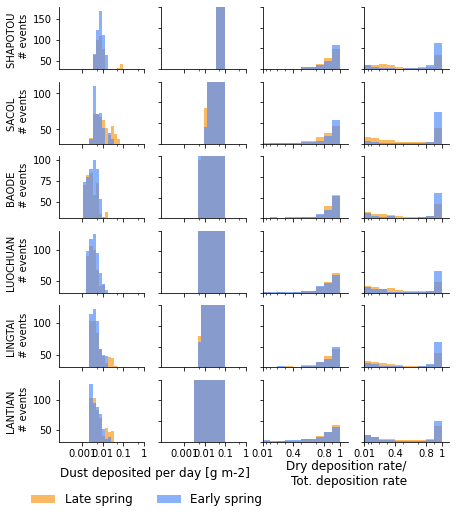

In [5]:
fig, axes = plt.subplots(ncols=4,nrows=6, figsize=(7,8), sharex=False, sharey=False)
plot_deposition_ratio_histogram(dfdp2m,dfwp2m,axes[:,2])
plot_deposition_ratio_histogram(dfdp20m,dfwp20m,axes[:,3])

plot_deposition_histogram(df2mtot,axes[:,0],np.logspace(np.log10(1e-4),np.log10(0.1),21))
plot_deposition_histogram(df20mtot,axes[:,1], np.logspace(np.log10(1e-4),np.log10(0.1),21))

remove_spines(axes[:,0], ylim=(30),side='right')
remove_ticks(axes[:,1])
remove_spines(axes[:,1],ylim=(0,30), side='right')



remove_spines(axes[:,3], ylim=(0,15),side='right')
remove_ticks(axes[:,1])
remove_spines(axes[:,2],ylim=(0,15), side='right')

remove_ticks(axes[:,3])
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        if j > 1:
            axes[i,j].set_xticks([0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.7,0.8,0.9,1], minor=True)
            axes[i,j].set_xticks([0.01,0.4,0.8,1],labels=[0.01, 0.4, 0.8,1])
        else:
            axes[i,j].set_xticks([5e-3,5e-2, 5e-1], minor=True)
            axes[i,j].set_xticks([1e-3,1e-2, 1e-1, 1],labels=[1e-3,1e-2, 1e-1, 1])

        if i==axes.shape[0]-1:
            pass
        else:
            axes[i,j].set_xticklabels([])

for ax, site in zip(axes[:,0].ravel(), locs):
    ax.set_ylabel(f"{site} \n # events")
for ax in axes[:,-1].ravel():
    ax.set_ylabel('')
    
for ax, site in zip(axes[:,2].ravel(), locs):
    ax.set_ylabel("")
    ax.set_yticklabels([])

    
fig.text(0.315, 0.07, "Dust deposited per day [g m-2]",va='center', ha='center'
         ,size='large',transform=fig.transFigure)

fig.text(0.7, 0.07, "Dry deposition rate/ \nTot. deposition rate",va='center', ha='center'
         ,size='large',transform=fig.transFigure)

h,l =axes[0,0].get_legend_handles_labels()
fig.legend(h, ['Late spring', 'Early spring'],bbox_to_anchor=(0.55,0.055),ncol=2, frameon=False,fontsize='large')
if to_file:
    plt.savefig(snakemake.output.outpath, bbox_inches='tight')

SHAPOTOU    0.003231
SACOL       0.001899
BAODE       0.000664
LUOCHUAN    0.001042
LINGTAI     0.001396
LANTIAN     0.001207
Name: 0.33, dtype: float64
SHAPOTOU    0.035726
SACOL       0.007281
BAODE       0.003696
LUOCHUAN    0.003203
LINGTAI     0.003682
LANTIAN     0.002204
Name: 0.33, dtype: float64
SHAPOTOU    0.0
SACOL       0.0
BAODE       0.0
LUOCHUAN    0.0
LINGTAI     0.0
LANTIAN     0.0
Name: 0.33, dtype: float64
SHAPOTOU    0.0
SACOL       0.0
BAODE       0.0
LUOCHUAN    0.0
LINGTAI     0.0
LANTIAN     0.0
Name: 0.33, dtype: float64


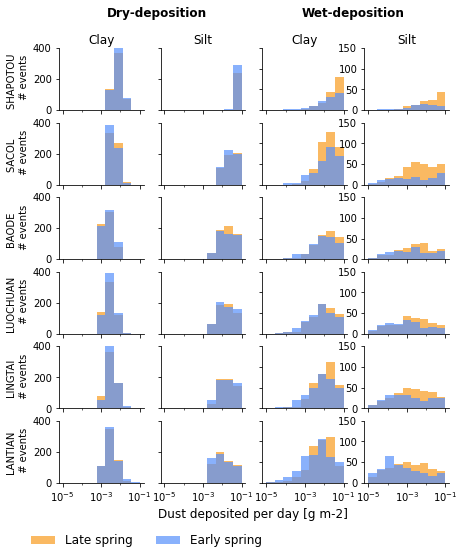

In [6]:
fig,axes = plt.subplots(ncols=4,nrows=6, figsize=(7,8), sharex=True, sharey=False)
plot_deposition_histogram(dfdp2m,axes[:,0])
plot_deposition_histogram(dfdp20m,axes[:,1])
plot_deposition_histogram(dfwp2m,axes[:,2])
plot_deposition_histogram(dfwp20m,axes[:,3])

axes[0,0].set_title('Clay',loc='center',y=.97)
axes[0,1].set_title('Silt',loc='center',y=.97)
axes[0,2].set_title('Clay',loc='center',y=.97)
axes[0,3].set_title('Silt',loc='center',y=.97)
remove_spines(axes[:,:2], ylim=(0,400),side='right')
remove_ticks(axes[:,1:2])
remove_spines(axes[:,2:],ylim=(0,150), side='right')
remove_ticks(axes[:,2:3])
axes[-1,0].set_xticks([1e-5,1e-3,1e-1])
axes[-1,0].set_xticks([1e-4,1e-2], minor=True, labels=[])
# axes[-1,0].xaxis.set_minor_locator(LogLocator(num))
fig.text(0.32,0.94,'Dry-deposition', va='center', ha='center', weight='semibold'
         ,size='large',transform=fig.transFigure)
fig.text(0.71,0.94,'Wet-deposition', va='center', ha='center', weight='semibold'
         ,size='large',transform=fig.transFigure)


fig.text(0.51, 0.07, "Dust deposited per day [g m-2]",va='center', ha='center'
         ,size='large',transform=fig.transFigure)
h,l =axes[0,0].get_legend_handles_labels()

for ax, site in zip(axes[:,0].ravel(), locs):
    ax.set_ylabel(f"{site} \n # events")
for ax in axes[:,-1].ravel():
    ax.set_ylabel('')
    
fig.legend(h, ['Late spring', 'Early spring'],bbox_to_anchor=(0.55,0.055),ncol=2, frameon=False,fontsize='large')
if to_file:
    plt.savefig(snakemake.output.outpath, bbox_inches='tight')